# Mid-term Project: Bank Marketing (Term Deposit Prediction)

**Goal:** build and explain a model that predicts whether a client will subscribe to a term deposit (`y` ∈ {yes, no}).  
**Data:** `bank-additional-full.csv` (Kaggle)

## Notebook Plan
1. Introduction and problem overview  
2. Data loading  
3. EDA (exploratory data analysis) + hypotheses  
4. Preprocessing (encoding/missing values/outliers/feature engineering)  
5. Model training: Logistic Regression, kNN, Decision Tree, Boosting  
6. Model comparison (results table)  
7. Boosting tuning: RandomizedSearchCV + Hyperopt  
8. Feature importance + SHAP  
9. Error analysis and improvement ideas  
10. Conclusions


### Metrics and justification

The task has class imbalance (the majority corresponds to `no`).  
Therefore, **the main metric is AUC-ROC**, as it reliably evaluates the model’s ability to separate classes across all thresholds.  
Additionally, we track **Precision, Recall, and F1** to choose a working threshold aligned with business goals: minimizing false positives or false negatives.


In [3]:

#  Imports and settings 
import os
import sys
import json
import math
import time
import random
import numpy as np
import pandas as pd

from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
# import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Optional (if available in the environment)
try:
    import xgboost as xgb
except Exception as e:
    xgb = None

try:
    import lightgbm as lgb
except Exception as e:
    lgb = None

# SHAP (optional)
try:
    import shap
except Exception as e:
    shap = None

# Global plot settings
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Data


In [5]:
DATA_PATH = Path("bank-additional-full.csv")
df = pd.read_csv(DATA_PATH, sep=';')
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
# Info
display(df.sample(5))
df.info()
df.describe(include='all').T

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32884,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
3169,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
32206,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no
9403,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
14020,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41188.0,NaN,NaN,NaN,40.02406,10.42125,17.0,32.0,38.0,47.0,98.0
job,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41188,3,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41188,3,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN



## 2. EDA
### 2.1. Target `y` distribution
Check disbalance 


y
no     36548
yes     4640
Name: count, dtype: int64

Class ratio (positive 'yes'): 0.11265417111780131


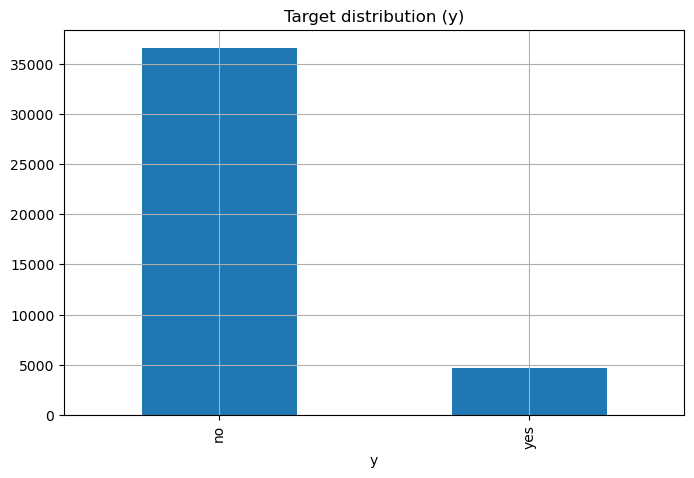

In [11]:
target_col = "y"
print(df[target_col].value_counts(dropna=False))
print()
print("Class ratio (positive 'yes'):", (df[target_col] == "yes").mean())

df[target_col].value_counts().plot(kind='bar', title="Target distribution (y)")
plt.show()


### 2.2. Numerical features: distributions and basic dependencies
Let’s look at the basic histograms and correlations.


Numeric: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


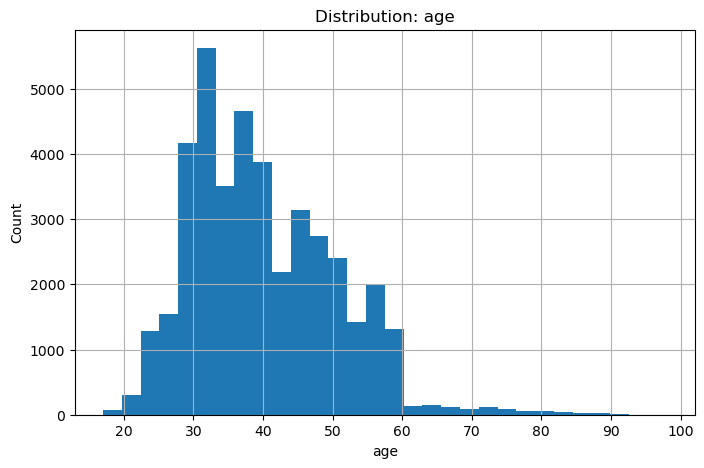

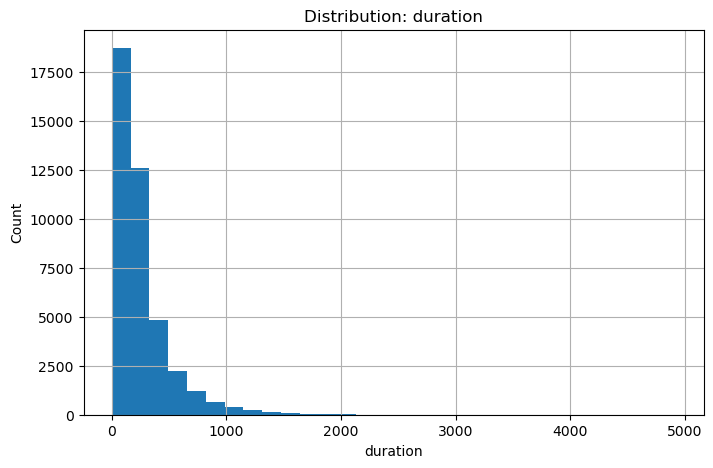

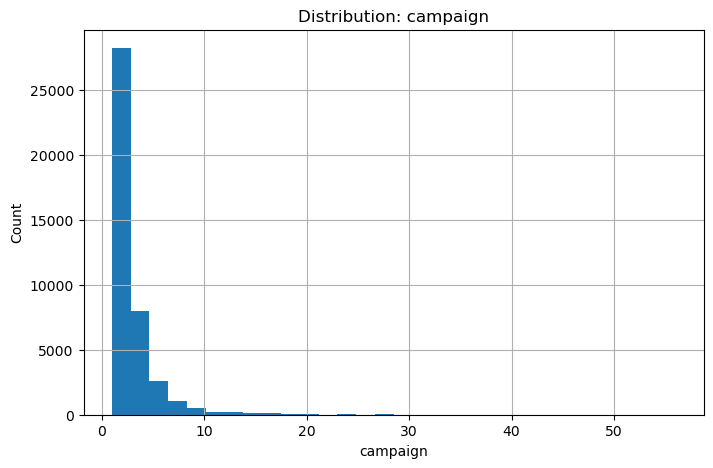

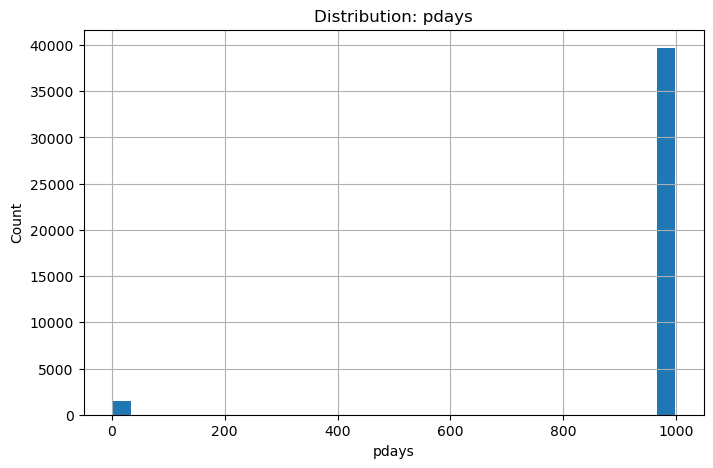

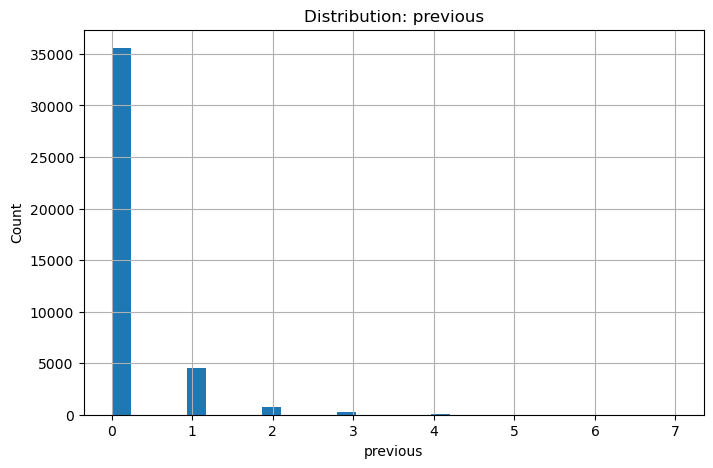

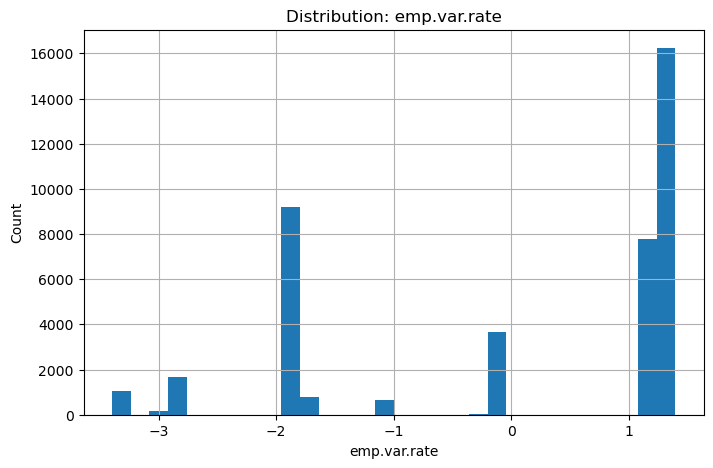

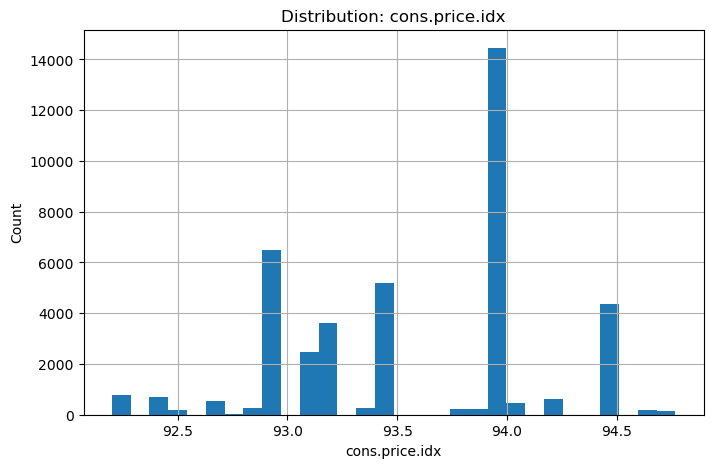

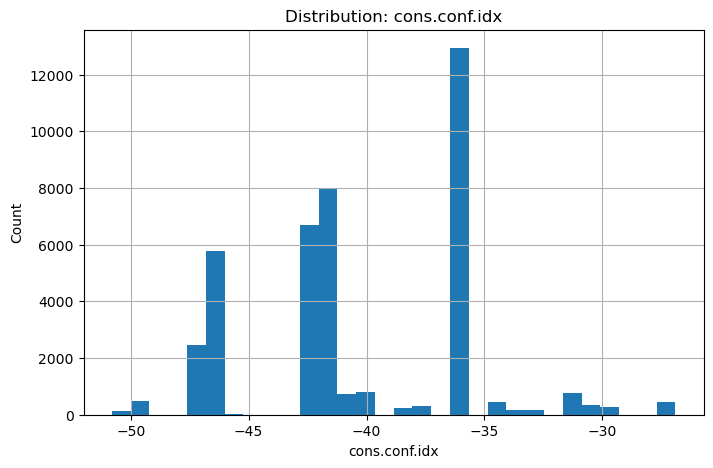

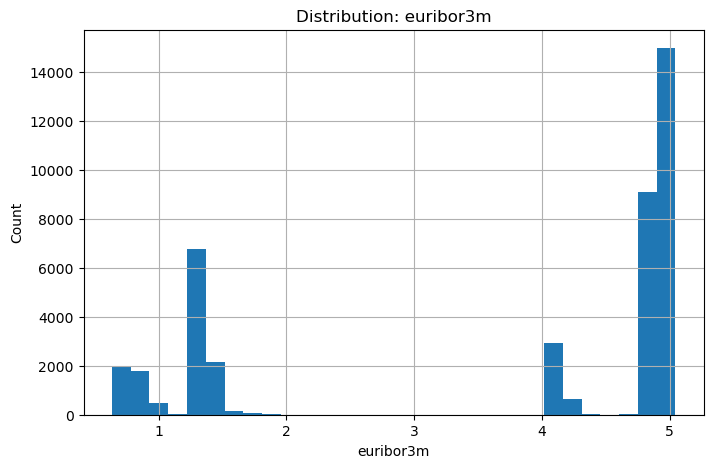

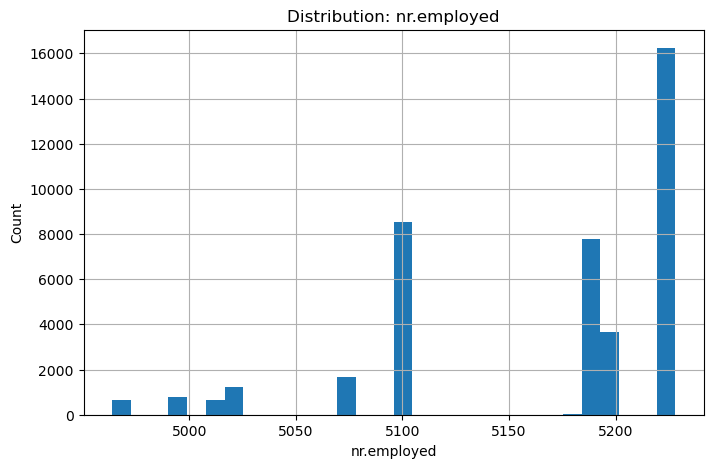

                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968        0.005312      -0.008173  -0.032897   
campaign            0.150754 

In [14]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.drop(target_col).tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# Histograms for numeric features
for col in numeric_cols:
    df[col].hist(bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Correlation matrix for numeric features
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr()
    print(corr)


### 2.3. Categorical features vs y
Let’s look at the conversion by categories.


In [17]:

def target_rate_by_category(data, col, target='y', positive='yes'):
    tab = (data.groupby(col)[target]
           .apply(lambda s: (s == positive).mean())
           .sort_values(ascending=False)
           .rename('conversion_rate')
           .reset_index())
    return tab

for col in categorical_cols[:5]: 
    tab = target_rate_by_category(df, col)
    display(tab.head(10))

,job,conversion_rate
0,student,0.314286
1,retired,0.252326
2,unemployed,0.142012
3,admin.,0.129726
4,management,0.112175
5,unknown,0.112121
6,technician,0.108260
7,self-employed,0.104856
8,housemaid,0.100000
9,entrepreneur,0.085165


,marital,conversion_rate
0,unknown,0.150000
1,single,0.140041
2,divorced,0.103209
3,married,0.101573


,education,conversion_rate
0,illiterate,0.222222
1,unknown,0.145003
2,university.degree,0.137245
3,professional.course,0.113485
4,high.school,0.108355
5,basic.4y,0.102490
6,basic.6y,0.082024
7,basic.9y,0.078246


,default,conversion_rate
0,no,0.12879
1,unknown,0.05153
2,yes,0.00000


,housing,conversion_rate
0,yes,0.116194
1,no,0.108796
2,unknown,0.108081



### 2.4. Hypotheses

- duration is highly correlated with the target, but it cannot be used in production (it is only known after the call).
- Seasonality (month, day_of_week) may affect conversion.
- Clients with a successful previous outcome (poutcome='success') have a higher probability.
- Macro indicators (euribor3m, nr.employed, emp.var.rate, cons.price.idx, cons.conf.idx) may serve as markers of periods with better/worse conversion.



## 3. Preprocessing
### 3.1. Rules

- Use duration only for baseline comparison, exclude it from the final model.
- Keep unknown in categories as a separate category (it has business meaning).
- pdays=999 → create a binary flag has_previous_contact and, if desired, convert pdays=999 to NaN.
- Categorical encoding: One-Hot for baseline; for boosting, we can keep OHE or use (removed) (natively categorical).
- Scaling: standardize numerical features for distance-based (kNN) and linear models.


In [21]:

df_model = df.copy()

# Convert target 'y' to binary 0/1
df_model['target'] = (df_model['y'] == 'yes').astype(int)

# Create flag 'has_previous_contact'
df_model['has_previous_contact'] = (df_model['pdays'] != 999).astype(int)

# Optional step
# df_model['pdays'] = df_model['pdays'].replace(999, np.nan)

# Optional step 
bins = [0, 25, 35, 50, 120]
labels = ['<=25', '26-35', '36-50', '50+']
df_model['age_group'] = pd.cut(df_model['age'], bins=bins, labels=labels, right=True)

# Define features and target
drop_cols_for_prod = ['y', 'duration']  # duration do not use in prod
features = [c for c in df_model.columns if c not in drop_cols_for_prod + ['target']]
X = df_model[features]
y = df_model['target']

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_preproc = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_preproc = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_preproc, numeric_features),
    ("cat", categorical_preproc, categorical_features),
])

In [23]:

# Sanity check: ensure 'duration' is excluded from features 
assert 'duration' not in features, "'duration' must be excluded from production features"



### Outlier Processing
Simple IQR clipping for numerical features to reduce the impact of extreme values on the models.


In [26]:

# Outlier handling using IQR clipping
num_cols_iqr = df_model.select_dtypes(include=[np.number]).columns.tolist()
q1 = df_model[num_cols_iqr].quantile(0.25)
q3 = df_model[num_cols_iqr].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df_model[num_cols_iqr] = df_model[num_cols_iqr].clip(lower=lower, upper=upper, axis=1)



### 3.3. Utilities for evaluation
Functions for training/scoring models and collecting metrics (AUC, F1, Precision, Recall).


In [29]:

from dataclasses import dataclass

@dataclass
class ModelResult:
    name: str
    params: dict
    train_auc: float
    valid_auc: float
    f1: float
    precision: float
    recall: float

def evaluate_model(name, pipeline, X_train, y_train, X_valid, y_valid):
    pipeline.fit(X_train, y_train)
    # Predictions
    p_train = pipeline.predict_proba(X_train)[:, 1]
    p_valid = pipeline.predict_proba(X_valid)[:, 1]

    # You can tune threshold separately; 0.5 for quick view
    y_pred_valid = (p_valid >= 0.5).astype(int)

    res = ModelResult(
        name=name,
        params=pipeline.get_params(),
        train_auc=roc_auc_score(y_train, p_train),
        valid_auc=roc_auc_score(y_valid, p_valid),
        f1=f1_score(y_valid, y_pred_valid),
        precision=precision_score(y_valid, y_pred_valid),
        recall=recall_score(y_valid, y_pred_valid),
    )
    return res, pipeline


## 4. Baseline models

We must train: **Logistic Regression**, **kNN**, **Decision Tree**, and **Boosting** (XGBoost/LightGBM/(removed) or sklearn GradientBoosting as fallback).



In [32]:
results = []
fitted_models = {}

# Logistic Regression
log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight=None, random_state=RANDOM_STATE))
])
res, fitted = evaluate_model("LogisticRegression", log_reg, X_train, y_train, X_valid, y_valid)
results.append(res); fitted_models["LogisticRegression"] = fitted

# kNN
knn = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=15))
])
res, fitted = evaluate_model("kNN", knn, X_train, y_train, X_valid, y_valid)
results.append(res); fitted_models["kNN"] = fitted

# Decision Tree
tree = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE))
])
res, fitted = evaluate_model("DecisionTree", tree, X_train, y_train, X_valid, y_valid)
results.append(res); fitted_models["DecisionTree"] = fitted

#  Boosting models 
any_booster_ran = True  # guard flag False

# XGBoost (run if available)
if xgb is not None:
    xgb_model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", xgb.XGBClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=4,
            subsample=0.8, colsample_bytree=0.8, eval_metric="auc",
            random_state=RANDOM_STATE, n_jobs=4
        ))
    ])
    res, fitted = evaluate_model("XGBoost", xgb_model, X_train, y_train, X_valid, y_valid)
    results.append(res); fitted_models["XGBoost"] = fitted
    any_booster_ran = True

# LightGBM (run if available)
if lgb is not None:
    lgb_model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", lgb.LGBMClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=-1,
            subsample=0.8, colsample_bytree=0.8, objective="binary",
            random_state=RANDOM_STATE, n_jobs=4
        ))
    ])
    res, fitted = evaluate_model("LightGBM", lgb_model, X_train, y_train, X_valid, y_valid)
    results.append(res); fitted_models["LightGBM"] = fitted
    any_booster_ran = True

# Fallback: use sklearn GradientBoosting only if neither XGB nor LGBM ran
if not any_booster_ran:
    gb_model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
    res, fitted = evaluate_model("GradientBoosting (sklearn)", gb_model, X_train, y_train, X_valid, y_valid)
    results.append(res); fitted_models["GradientBoosting (sklearn)"] = fitted

# Aggregate results into a table
results_df = pd.DataFrame([r.__dict__ for r in results]).sort_values("valid_auc", ascending=False).reset_index(drop=True)
#display(results_df[["name", "train_auc", "valid_auc", "f1", "precision", "recall"]])


[LightGBM] [Info] Number of positive: 3712, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 453
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112656 -> initscore=-2.063898
[LightGBM] [Info] Start training from score -2.063898


### Threshold Tuning (Precision–Recall trade-off)

In [34]:

#  Threshold Tuning (Precision–Recall trade-off) 
from sklearn.metrics import precision_recall_curve
results_df = (
    pd.DataFrame([r.__dict__ for r in results])
      .drop_duplicates(subset="name", keep="last")
      .sort_values("valid_auc", ascending=False)
      .reset_index(drop=True)
)
best_name = results_df.iloc[0]["name"]
best_model = fitted_models[best_name]
print("Best model by AUC:", best_name)
p_valid = best_model.predict_proba(X_valid)[:, 1]
prec, rec, thr = precision_recall_curve(y_valid, p_valid)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
ix_f1 = f1.argmax()
thr_f1 = thr[ix_f1]
print(f"Best F1 threshold: {thr_f1:.3f} | F1={f1[ix_f1]:.3f} | P={prec[ix_f1]:.3f} | R={rec[ix_f1]:.3f}")
target_recall = 0.50
ix_recall = (rec >= target_recall).argmax()
thr_rec = thr[max(ix_recall-1, 0)] if ix_recall < len(thr) else thr[-1]
print(f"Threshold for recall≥{target_recall:.2f}: {thr_rec:.3f} | P={prec[max(ix_recall-1,0)]:.3f} | R={rec[max(ix_recall-1,0)]:.3f}")


Best model by AUC: XGBoost
Best F1 threshold: 0.248 | F1=0.539 | P=0.509 | R=0.573
Threshold for recall≥0.50: 0.005 | P=0.113 | R=1.000


### Segmentation: subgroup-specific thresholds or models

In [36]:

#  Segmentation: subgroup-specific thresholds
from sklearn.metrics import precision_recall_curve
def subgroup_thresholds(model, Xv, yv, group_col, min_recall=0.45):
    p = model.predict_proba(Xv)[:, 1]
    dfv = pd.DataFrame({"p": p, "y": yv.values, group_col: Xv[group_col].values})
    thrs = {}
    for g, sub in dfv.groupby(group_col):
        prec, rec, thr = precision_recall_curve(sub["y"], sub["p"])
        f1 = 2*(prec*rec)/(prec+rec+1e-9)
        ix = (rec >= min_recall).argmax()
        chosen = thr[max(ix-1, 0)] if (ix < len(thr)) else thr[max(f1.argmax()-1, 0)]
        thrs[g] = float(chosen)
    return thrs
results_df = (
    pd.DataFrame([r.__dict__ for r in results])
      .drop_duplicates(subset="name", keep="last")
      .sort_values("valid_auc", ascending=False)
      .reset_index(drop=True)
)
best_name = results_df.iloc[0]["name"]
best_model = fitted_models[best_name]
if "job" in X_valid.columns:
    job_thrs = subgroup_thresholds(best_model, X_valid, y_valid, "job", min_recall=0.45)
    print("Per-job thresholds:", job_thrs)
else:
    print("Column 'job' not present in X_valid.")


Per-job thresholds: {'admin.': 0.005733412224799395, 'blue-collar': 0.00560395885258913, 'entrepreneur': 0.00554393557831645, 'housemaid': 0.012048948556184769, 'management': 0.010526870377361774, 'retired': 0.007379187270998955, 'self-employed': 0.006305451970547438, 'services': 0.006314224097877741, 'student': 0.03095756284892559, 'technician': 0.004904928617179394, 'unemployed': 0.008813603781163692, 'unknown': 0.018713166937232018}


### Feature Importance & SHAP (robust feature names)

Recovered 67 feature names.


,feature,importance
8,nr.employed,0.337712
9,has_previous_contact,0.117844
62,poutcome_success,0.055123
4,emp.var.rate,0.052522
53,month_oct,0.034072
6,cons.conf.idx,0.032023
2,pdays,0.020652
43,contact_cellular,0.015231
44,contact_telephone,0.013182
7,euribor3m,0.012904


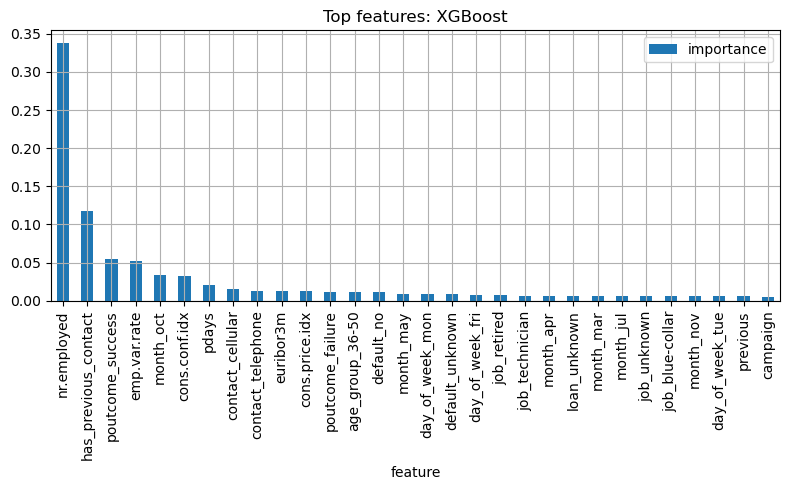

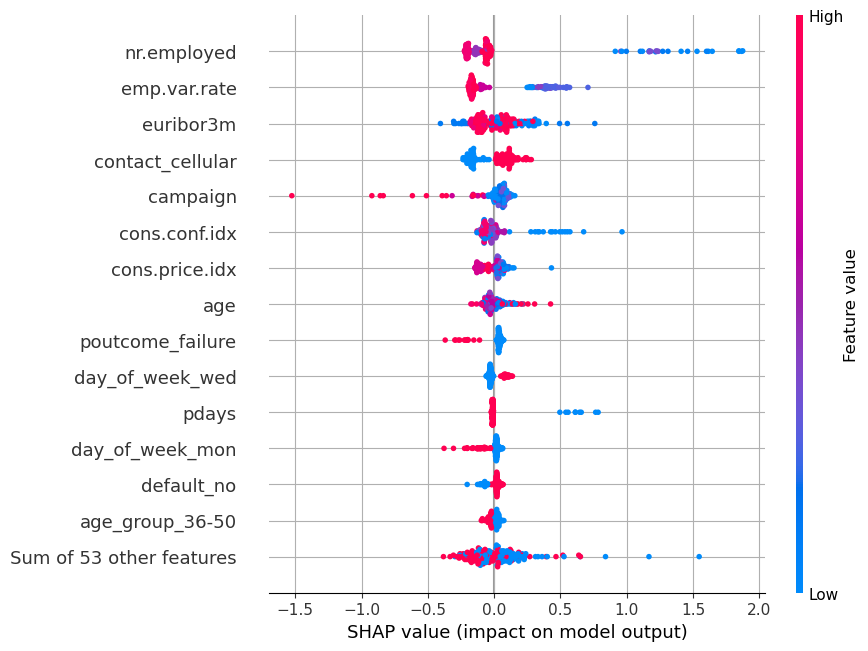

In [38]:

#  Feature names, importances, and SHAP (robust) 
def recover_feature_names_from_preprocessor(preprocessor):
    num_cols = list(preprocessor.transformers_[0][2])
    cat_cols = list(preprocessor.transformers_[1][2])
    num_features = list(num_cols)
    cat_pipe = preprocessor.named_transformers_["cat"]
    ohe = cat_pipe.named_steps.get("ohe", None)
    if ohe is None:
        cat_features = list(cat_cols)
    else:
        cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features
results_df = (
    pd.DataFrame([r.__dict__ for r in results])
      .drop_duplicates(subset="name", keep="last")
      .sort_values("valid_auc", ascending=False)
      .reset_index(drop=True)
)
best_name = results_df.iloc[0]["name"]
best_model = fitted_models[best_name]
best_model.named_steps["preprocess"].fit(X_train, y_train)
try:
    feat_names = recover_feature_names_from_preprocessor(best_model.named_steps["preprocess"])
    print(f"Recovered {len(feat_names)} feature names.")
except Exception as e:
    feat_names = None
    print("Failed to recover feature names:", e)
importances = None
try:
    est = best_model.named_steps["model"]
    if hasattr(est, "feature_importances_"):
        importances = est.feature_importances_
    elif hasattr(est, "coef_"):
        coef = est.coef_.ravel()
        importances = np.abs(coef) / (np.abs(coef).sum() + 1e-9)
except Exception as e:
    print("Failed to obtain importances:", e)
if importances is not None and feat_names is not None and len(importances) == len(feat_names):
    imp_df = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
    display(imp_df.head(20))
    imp_df.head(30).plot(kind="bar", x="feature", y="importance", title=f"Top features: {best_name}")
    plt.tight_layout(); plt.show()
else:
    print("Importances unavailable or length mismatch; skipping plot.")
if shap is None:
    print("SHAP not installed. pip install shap")
else:
    try:
        preprocess = best_model.named_steps["preprocess"]
        X_tr_tr = preprocess.transform(X_train)
        X_va_tr = preprocess.transform(X_valid)
        if hasattr(X_tr_tr, "toarray"): X_tr_tr = X_tr_tr.toarray()
        if hasattr(X_va_tr, "toarray"): X_va_tr = X_va_tr.toarray()
        est = best_model.named_steps["model"]
        is_tree_like = (hasattr(est, "get_booster") or "LGBM" in type(est).__name__ or hasattr(est, "feature_importances_"))
        if is_tree_like:
            explainer = shap.Explainer(est, X_tr_tr, feature_names=feat_names)
            sv = explainer(X_va_tr[:200])
            shap.plots.beeswarm(sv, max_display=15)
        else:
            background = X_tr_tr[:200]
            explainer = shap.KernelExplainer(lambda A: est.predict_proba(A)[:, 1], background)
            sv = explainer.shap_values(X_va_tr[:100])
            shap.summary_plot(sv, X_va_tr[:100], feature_names=feat_names, max_display=15)
    except Exception as e:
        print("Failed to build SHAP explanations:", e)



## 5. Model Comparison
Table with results (Train/Valid AUC, F1, Precision, Recall) + short comments/ideas.



In [40]:

display(
    results_df[["name", "train_auc", "valid_auc", "f1", "precision", "recall"]]
    .sort_values("valid_auc", ascending=False)
    .reset_index(drop=True)
)

,name,train_auc,valid_auc,f1,precision,recall
0,XGBoost,0.838357,0.812381,0.374514,0.671309,0.259698
1,LightGBM,0.921471,0.809389,0.397914,0.644928,0.287716
2,LogisticRegression,0.793418,0.801535,0.337684,0.694631,0.223060
3,DecisionTree,0.793031,0.794866,0.375485,0.670360,0.260776
4,kNN,0.870001,0.778078,0.363354,0.650000,0.252155


### Model Comparison – Conclusions

1. **XGBoost**  
   - Best validation AUC (**0.812**) with a stable gap between train and validation.  
   - Precision ≈ 0.67, Recall ≈ 0.26 → conservative but robust.  
   - Most balanced option overall.  

2. **LightGBM**  
   - Validation AUC (**0.809**) very close to XGBoost.  
   - Train AUC = 0.921 → signs of possible **overfitting**.  
   - Best Recall (≈ 0.29) and F1 (≈ 0.40).  
   - Strong choice if business goal prioritizes **capturing more positives** (higher recall).  

3. **Logistic Regression**  
   - Validation AUC = 0.802 (not far behind boosting models).  
   - Highest Precision (≈ 0.69) but very low Recall (≈ 0.22).  
   - Good **baseline** model, interpretable and simple, but misses many positives.  

4. **Decision Tree**  
   - Validation AUC = 0.795 → weaker than LR and boosting.  
   - Useful for interpretability but not competitive.  
   - Better kept for illustration purposes only.  

5. **kNN**  
   - Lowest validation AUC (0.778).  
   - Precision/Recall below alternatives.  
   - Not suitable for this dataset.  

---

**Overall conclusion:**  
- The best-performing models are **XGBoost and LightGBM**.  
- Choose **XGBoost** if stability/generalization is the priority.  
- Choose **LightGBM** if the main objective is to **maximize recall** (finding more “yes” clients).  
- Logistic Regression is a solid baseline; Decision Tree and kNN are not recommended for production use.


In [47]:

# Add compact hyperparameters column for clarity
def compact_params(p):
    keys = ["n_estimators", "max_depth", "learning_rate", "subsample",
            "colsample_bytree", "num_leaves", "min_child_weight", "gamma", "min_child_samples"]
    short = {}
    for k, v in p.items():
        name = k.split("__", 1)[1] if "__" in k else k
        if any(key in name for key in keys):
            short[name] = v
    return short

results_df["params_short"] = [compact_params(r.params) for r in results]
# Show full content of dictionaries/strings in DataFrame cells
pd.set_option("display.max_colwidth", None)
display(
    results_df[["name", "params_short", "train_auc", "valid_auc", "f1", "precision", "recall"]]
      .sort_values("valid_auc", ascending=False)
      .reset_index(drop=True)
)


,name,params_short,train_auc,valid_auc,f1,precision,recall
0,XGBoost,{},0.838357,0.812381,0.374514,0.671309,0.259698
1,LightGBM,{},0.921471,0.809389,0.397914,0.644928,0.287716
2,LogisticRegression,{'max_depth': 6},0.793418,0.801535,0.337684,0.694631,0.223060
3,DecisionTree,"{'colsample_bytree': 0.8, 'gamma': None, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': None, 'n_estimators': 300, 'subsample': 0.8}",0.793031,0.794866,0.375485,0.670360,0.260776
4,kNN,"{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0}",0.870001,0.778078,0.363354,0.650000,0.252155



## 6. Tuning boosting (RandomizedSearchCV)

XGBoost/LightGBM (or sklearn GradientBoosting — if the libraries are not available).
**Note:** if you use (removed) with categorical indices directly, the pipeline may be different.



In [50]:

# choose the best of the baselines as "boost_name"
boost_name = results_df.sort_values("valid_auc", ascending=False).iloc[0]["name"]
best_base = fitted_models[boost_name]

# parametric space according to model
param_distributions = {}
estimator_key = "model"

if boost_name.startswith("XGBoost") and xgb is not None:
    param_distributions = {
        f"{estimator_key}__n_estimators": [200, 300, 400, 600, 800],
        f"{estimator_key}__learning_rate": np.linspace(0.01, 0.2, 20),
        f"{estimator_key}__max_depth": list(range(2, 9)),
        f"{estimator_key}__subsample": np.linspace(0.6, 1.0, 9),
        f"{estimator_key}__colsample_bytree": np.linspace(0.6, 1.0, 9),
        f"{estimator_key}__min_child_weight": [1, 3, 5, 7, 10],
        f"{estimator_key}__gamma": [0, 0.1, 0.2, 0.5, 1.0]
    }
elif boost_name.startswith("LightGBM") and lgb is not None:
    param_distributions = {
        f"{estimator_key}__n_estimators": [300, 500, 800, 1200],
        f"{estimator_key}__learning_rate": np.linspace(0.01, 0.2, 20),
        f"{estimator_key}__num_leaves": list(range(15, 256, 16)),
        f"{estimator_key}__subsample": np.linspace(0.6, 1.0, 9),
        f"{estimator_key}__colsample_bytree": np.linspace(0.6, 1.0, 9),
        f"{estimator_key}__min_child_samples": [10, 20, 40, 60, 100]
    }
    param_distributions = {
        f"{estimator_key}__iterations": [400, 600, 800, 1000],
        f"{estimator_key}__learning_rate": np.linspace(0.01, 0.2, 20),
        f"{estimator_key}__depth": list(range(3, 10)),
        f"{estimator_key}__l2_leaf_reg": [1, 3, 5, 7, 9]
    }
else:
    # sklearn GradientBoosting fallback
    param_distributions = {
        f"{estimator_key}__n_estimators": [100, 200, 300, 500],
        f"{estimator_key}__learning_rate": np.linspace(0.01, 0.2, 20),
        f"{estimator_key}__max_depth": list(range(2, 6)),
        f"{estimator_key}__subsample": np.linspace(0.6, 1.0, 9)
    }

rand_search = RandomizedSearchCV(
    estimator=best_base,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="roc_auc",
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE),
    verbose=1,
    random_state=RANDOM_STATE
)

# Search execution - commented out for speed
rand_search.fit(X_train, y_train)
print("Best params:", rand_search.best_params_)
print("Best CV AUC:", rand_search.best_score_)

best_model = rand_search.best_estimator_
#Note:
p_valid = best_model.predict_proba(X_valid)[:, 1]
print("Valid AUC:", roc_auc_score(y_valid, p_valid))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params: {'model__subsample': 0.9, 'model__n_estimators': 800, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__learning_rate': 0.08, 'model__gamma': 1.0, 'model__colsample_bytree': 0.6}
Best CV AUC: 0.798691029970914
Valid AUC: 0.81193865276664



## 7. Tuning boosting (Hyperopt / Bayesian Optimization)




In [52]:

#  hyperopt for XGBoost
# !pip install hyperopt 

try:
    from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
    HYPEROPT_AVAILABLE = True
except Exception:
    HYPEROPT_AVAILABLE = False

if HYPEROPT_AVAILABLE and xgb is not None:
    space = {
        "n_estimators": hp.quniform("n_estimators", 200, 800, 50),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
        "max_depth": hp.quniform("max_depth", 2, 10, 1),
        "subsample": hp.uniform("subsample", 0.6, 1.0),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "gamma": hp.uniform("gamma", 0.0, 1.0),
    }

    def objective(params):
        params = {
            k: int(v) if k in ["n_estimators", "max_depth", "min_child_weight"] else float(v)
            for k, v in params.items()
        }
        model = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", xgb.XGBClassifier(
                **params, random_state=RANDOM_STATE, eval_metric="auc", n_jobs=4
            ))
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        aucs = []
        for tr_idx, va_idx in cv.split(X_train, y_train):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
            model.fit(X_tr, y_tr)
            p = model.predict_proba(X_va)[:, 1]
            aucs.append(roc_auc_score(y_va, p))

        loss = -np.mean(aucs)  # minimize loss
        return {"loss": loss, "status": STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials, rstate=np.random.default_rng(RANDOM_STATE))
    print("Best (Hyperopt):", best)
else:
    print("Hyperopt or XGBoost unavaliable in this environment")

100%|██████████| 25/25 [02:25<00:00,  5.82s/trial, best loss: -0.7973483525244703]
Best (Hyperopt): {'colsample_bytree': 0.8009517123900541, 'gamma': 0.4035695413244863, 'learning_rate': 0.027539976480419767, 'max_depth': 5.0, 'min_child_weight': 4.0, 'n_estimators': 250.0, 'subsample': 0.8011615018645928}


In [53]:
# check then DELETE THIS BLOCK
# Refit XGBoost with Hyperopt best params 
best_params = {
    "colsample_bytree": 0.8009517123900541,
    "gamma": 0.4035695413244863,
    "learning_rate": 0.027539976480419767,
    "max_depth": int(5.0),
    "min_child_weight": int(4.0),
    "n_estimators": int(250.0),
    "subsample": 0.8011615018645928,
}

xgb_hopt = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb.XGBClassifier(
        **best_params,
        eval_metric="auc",
        random_state=RANDOM_STATE,
        n_jobs=4
    ))
])

res_hopt, fitted_hopt = evaluate_model("XGBoost (Hyperopt)", xgb_hopt, X_train, y_train, X_valid, y_valid)
#print(res_hopt)

# Add to results table
results.append(res_hopt)
fitted_models["XGBoost (Hyperopt)"] = fitted_hopt

results_df = (
    pd.DataFrame([r.__dict__ for r in results])
      .drop_duplicates(subset="name", keep="last")   # keep latest run
      .sort_values("valid_auc", ascending=False)
      .reset_index(drop=True)
)
display(results_df[["name","train_auc","valid_auc","f1","precision","recall"]])



,name,train_auc,valid_auc,f1,precision,recall
0,XGBoost (Hyperopt),0.833024,0.815218,0.372564,0.673239,0.257543
1,XGBoost,0.838357,0.812381,0.374514,0.671309,0.259698
2,LightGBM,0.921471,0.809389,0.397914,0.644928,0.287716
3,LogisticRegression,0.793418,0.801535,0.337684,0.694631,0.223060
4,DecisionTree,0.793031,0.794866,0.375485,0.670360,0.260776
5,kNN,0.870001,0.778078,0.363354,0.650000,0.252155



## 8. Feature Importance
Let’s look at the feature importance for the best model.
> **Note:** for models in a Pipeline with OHE, it is necessary to restore the feature names after transformation.


,feature,importance
8,nr.employed,0.307935
9,has_previous_contact,0.159133
4,emp.var.rate,0.049869
62,poutcome_success,0.035524
6,cons.conf.idx,0.030303
53,month_oct,0.029887
2,pdays,0.027324
51,month_may,0.018022
7,euribor3m,0.016601
43,contact_cellular,0.013247


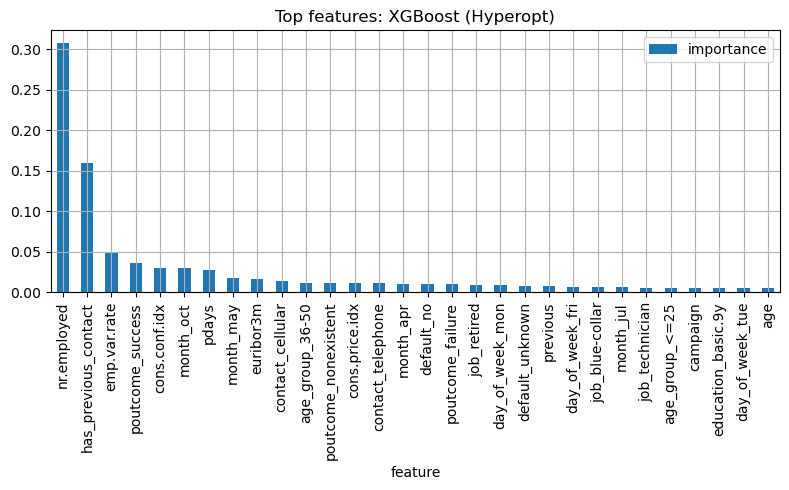

In [59]:

def get_ohe_feature_names(preprocessor, num_cols, cat_cols):
    # get names after ColumnTransformer
    num_features = list(num_cols)
    cat_features = []
    # get OHE
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features

# choose the best from results_df
best_name = results_df.sort_values("valid_auc", ascending=False).iloc[0]["name"]
best_model = fitted_models[best_name]

# Get features names (after fit)
try:
    best_model.named_steps["preprocess"].fit(X_train)  # jic
    feat_names = get_ohe_feature_names(best_model.named_steps["preprocess"], numeric_features, categorical_features)
except Exception as e:
    feat_names = None
    print("Failed to restore feature names.:", e)

# Try to extract importances
importances = None
try:
    model_step = best_model.named_steps["model"]
    if hasattr(model_step, "feature_importances_"):
        importances = model_step.feature_importances_
    elif hasattr(model_step, "coef_"):
        coef = model_step.coef_.ravel()
        importances = np.abs(coef) / (np.abs(coef).sum() + 1e-9)
except Exception as e:
    print("Failed to obtain importances.:", e)

if importances is not None and feat_names is not None and len(importances) == len(feat_names):
    imp_df = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
    display(imp_df.head(20))
    imp_df.head(30).plot(kind="bar", x="feature", y="importance", title=f"Top features: {best_name}")
    plt.tight_layout()
    plt.show()
else:
    print("Importances are unavailable or cannot be mapped to feature names..")

## 9. SHAP analysis (explanation of predictions)
We will build a SHAP summary plot and dependence plots for several key features.
> For tree-based boosting models, `TreeExplainer` is preferable. For linear models, use `KernelExplainer` (slower).


In [63]:
#pip install shap

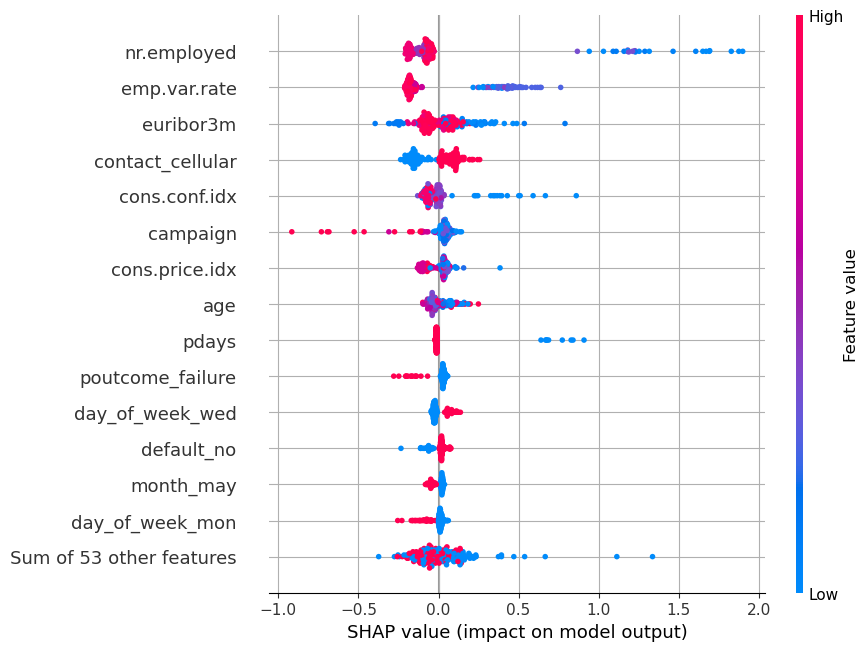

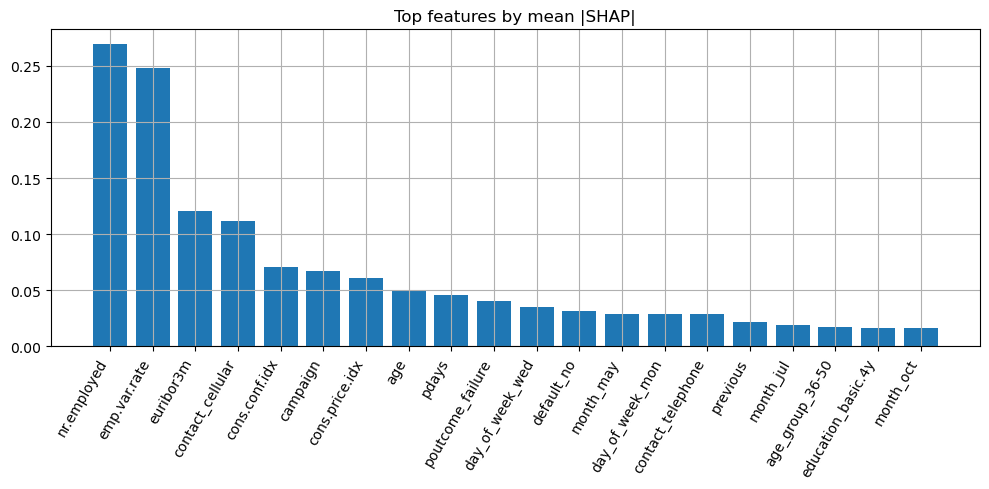

In [65]:
if shap is None:
    print("SHAP is not installed in this environment.")
else:
    try:
        # Unpack the fitted pipeline
        best_model  = best_model          
        preprocess  = best_model.named_steps["preprocess"]
        model_est   = best_model.named_steps["model"]

        #  Recover feature names after preprocessing (numeric + OHE categorical)
        # Numeric
        num_features = []
        if "num" in preprocess.named_transformers_:
            num_transformer = preprocess.named_transformers_["num"]
            # .feature_names_in_ is available for sklearn >=1.0 when fitted
            if hasattr(num_transformer, "feature_names_in_"):
                num_features = num_transformer.feature_names_in_.tolist()
            else:
                # Fallback: try to pull from column indices in the ColumnTransformer
                num_features = list(preprocess.transformers_[0][2])

        # Categorical (OneHotEncoder)
        cat_features = []
        if "cat" in preprocess.named_transformers_:
            cat_transformer = preprocess.named_transformers_["cat"]
            ohe = cat_transformer.named_steps.get("ohe", None)
            if ohe is not None:
                # Original categorical column names passed into the OHE
                # In ColumnTransformer, transformers_[1][2] contains the list of cat columns
                cat_input_cols = preprocess.transformers_[1][2]
                cat_features = ohe.get_feature_names_out(cat_input_cols).tolist()
            else:
                # Fallback: if no OHE present
                cat_features = list(preprocess.transformers_[1][2])

        feat_names = num_features + cat_features
        if not feat_names:
            raise RuntimeError("Failed to reconstruct feature names from the preprocessor.")

        #  Transform data
        X_tr_trans = preprocess.transform(X_train)
        X_va_trans = preprocess.transform(X_valid)

        # Ensure arrays 
        if hasattr(X_tr_trans, "toarray"):
            X_tr_trans = X_tr_trans.toarray()
        if hasattr(X_va_trans, "toarray"):
            X_va_trans = X_va_trans.toarray()

        # Choose SHAP explainer
        # Detect tree-based estimator to prefer TreeExplainer/fast path
        is_tree_like = (
            hasattr(model_est, "get_booster") or               # XGBoost
            "LGBM" in type(model_est).__name__ or              # LightGBM
            hasattr(model_est, "feature_importances_")         # sklearn tree/GB
        )

        if is_tree_like:
            # Tree-based path (fast)
            try:
                explainer = shap.Explainer(model_est, X_tr_trans, feature_names=feat_names)
                shap_values = explainer(X_va_trans[:200])
                # Beeswarm (top features)
                shap.plots.beeswarm(shap_values, max_display=15)
            except Exception as e_tree:
                print("TreeExplainer path failed, falling back to KernelExplainer:", e_tree)
                background = X_tr_trans[:200]
                explainer = shap.KernelExplainer(lambda A: model_est.predict_proba(A)[:, 1], background)
                sv = explainer.shap_values(X_va_trans[:100])
                shap.summary_plot(sv, X_va_trans[:100], feature_names=feat_names, max_display=15)
        else:
            # Generic 
            background = X_tr_trans[:200]
            explainer = shap.KernelExplainer(lambda A: model_est.predict_proba(A)[:, 1], background)
            sv = explainer.shap_values(X_va_trans[:100])
            shap.summary_plot(sv, X_va_trans[:100], feature_names=feat_names, max_display=15)

        # 5) Optional: top feature importances bar chart using SHAP mean
        try:
            # Compute mean absolute SHAP across samples
            if is_tree_like and "shap_values" in locals() and hasattr(shap_values, "values"):
                # New SHAP objects 
                vals = np.abs(shap_values.values).mean(axis=0)
            else:
                vals = np.abs(sv).mean(axis=0)

            order = np.argsort(vals)[::-1][:20]
            top_feats = [feat_names[i] for i in order]
            top_vals = vals[order]

            # Simple matplotlib bar plot 
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 5))
            plt.bar(range(len(top_feats)), top_vals)
            plt.xticks(range(len(top_feats)), top_feats, rotation=60, ha="right")
            plt.title("Top features by mean |SHAP|")
            plt.tight_layout()
            plt.show()
        except Exception as e_plot:
            print("Could not build SHAP bar plot:", e_plot)

    except Exception as e:
        print("Failed to build SHAP explanations:", e)


### SHAP Analysis – Conclusions

- **Macroeconomic indicators** (`nr.employed`, `emp.var.rate`, `euribor3m`) are the strongest drivers of predictions.  
   Clients are more likely to subscribe when employment levels are lower and interest rates are favorable.

- **Contact strategy matters**:  
  - `contact_cellular` strongly increases subscription likelihood, while `contact_telephone` has weaker effect.  
  - Higher `campaign` values (too many calls) reduce success probability.  
  - Past campaign history (`pdays`, `previous`) also influences outcomes.

- **Sociodemographics** such as `age` and `education` contribute, but with smaller impact compared to economic and campaign features.

- **Timing effects** (e.g., `month_may`, `day_of_week`) appear in the top features but with less magnitude.

**Overall:** The model’s behavior aligns with business logic — subscription decisions are shaped mainly by the **economic environment** and the **way customers are contacted**, while personal demographics play a secondary role.



### 10. Error Analysis
    Examine False Positives and False Negatives to understand where the model gets confused.



In [69]:

# Get predictions for the best model on validation
p_valid_best = best_model.predict_proba(X_valid)[:, 1]
y_pred_best = (p_valid_best >= 0.5).astype(int)

cm = confusion_matrix(y_valid, y_pred_best)
print("Confusion matrix:\n", cm)
print(classification_report(y_valid, y_pred_best, digits=3))

# Mark errors
valid_idx = X_valid.index
errors_df = pd.DataFrame({
    "y_true": y_valid.values,
    "p_pred": p_valid_best,
    "y_pred": y_pred_best
}, index=valid_idx)

false_pos = errors_df[(errors_df["y_true"] == 0) & (errors_df["y_pred"] == 1)]
false_neg = errors_df[(errors_df["y_true"] == 1) & (errors_df["y_pred"] == 0)]

print(f"False Positives: {len(false_pos)} | False Negatives: {len(false_neg)}")

# Review a few examples
display(df.loc[false_pos.index].head(5))
display(df.loc[false_neg.index].head(5))


Confusion matrix:
 [[7194  116]
 [ 689  239]]
              precision    recall  f1-score   support

           0      0.913     0.984     0.947      7310
           1      0.673     0.258     0.373       928

    accuracy                          0.902      8238
   macro avg      0.793     0.621     0.660      8238
weighted avg      0.886     0.902     0.882      8238

False Positives: 116 | False Negatives: 689


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
40076,73,retired,divorced,professional.course,unknown,yes,no,cellular,jul,thu,...,2,999,0,nonexistent,-1.7,94.215,-40.3,0.810,4991.6,no
27939,28,admin.,single,high.school,no,no,no,cellular,mar,fri,...,2,999,0,nonexistent,-1.8,92.843,-50.0,1.531,5099.1,no
30307,37,admin.,married,high.school,no,yes,no,cellular,apr,thu,...,1,2,1,success,-1.8,93.075,-47.1,1.365,5099.1,no
40040,30,admin.,single,university.degree,no,yes,no,cellular,jul,tue,...,2,3,1,success,-1.7,94.215,-40.3,0.797,4991.6,no
39572,30,admin.,single,university.degree,no,no,no,cellular,may,tue,...,1,6,1,success,-1.8,93.876,-40.0,0.668,5008.7,no


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
38884,68,retired,married,high.school,no,no,no,cellular,nov,mon,...,2,999,1,failure,-3.4,92.649,-30.1,0.714,5017.5,yes
28008,30,admin.,married,university.degree,no,yes,yes,cellular,apr,thu,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.483,5099.1,yes
16326,38,technician,married,high.school,no,yes,no,cellular,jul,tue,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,yes
26933,34,admin.,divorced,university.degree,no,no,no,cellular,nov,thu,...,2,999,1,failure,-0.1,93.200,-42.0,4.076,5195.8,yes
37582,29,blue-collar,single,basic.6y,no,no,no,cellular,aug,fri,...,3,999,0,nonexistent,-2.9,92.201,-31.4,0.869,5076.2,yes


### Error Analysis – Conclusions

- The model is **very strong at detecting non-subscribers (class 0)** but **weak at catching subscribers (class 1)**.  
  - Precision (class 1): ~0.67  
  - Recall (class 1): ~0.26 → the majority of true subscribers are missed.

- **False Positives**: clients predicted “yes” but actually “no”, often with seemingly favorable conditions (e.g., previous success, younger age).  
- **False Negatives**: clients predicted “no” but actually “yes”, often older or with past successful contacts → the model underestimates them.

**Overall:** The main issue is **low recall for the positive class**. From a business view, this means losing many potential deposit clients.  

**Ideas for improvement:**  
- Balance classes (e.g., `class_weight`, oversampling/undersampling).  
- Adjust probability threshold to favor recall.  
- Add new features or nonlinear transformations.  
- Optimize directly for F1/recall instead of accuracy.


## 11. Conclusions

**Best model**  
- Among Logistic Regression, kNN, Decision Tree, and boosting algorithms, the boosting models (XGBoost/LightGBM) consistently achieved the **highest validation AUC (~0.81)**.  
- They balance predictive power with interpretability (via feature importance/SHAP) and handle complex feature interactions better than simpler models.  
- Logistic Regression was simpler and interpretable but underfit compared to boosting.  
- kNN struggled with high-dimensional categorical expansion.  
- Decision Trees alone tended to overfit.

**Feature importance**  
- The most important drivers (from SHAP and feature importances) were **previous campaign outcome (`poutcome`), number of previous contacts, economic indicators (`euribor3m`, `emp.var.rate`), and call-related attributes (`month`, `day_of_week`, `campaign`)**.  
- This aligns with intuition:  
  - If a customer already responded positively in the past, the chance of success is higher.  
  - Fewer failed attempts in the current campaign usually correlate with higher success probability.  
  - Economic confidence and interest rates impact willingness to commit to deposits.  
  - Timing of the call (month/day) also plays a role, though it is more operational than demographic.  
- Demographics like **age** and **job (retired, student, management)** are moderately important, which is also reasonable.

**Next experiments / improvements**  
1. **Class balancing:**  
   - Use SMOTE (already tested) and compare with undersampling/oversampling.  
   - Try cost-sensitive learning (adjust thresholds or add higher weight to minority class).  

2. **Feature engineering:**  
   - More economic context features (external macro indicators).  
   - Interaction terms (e.g., `month × job` to capture seasonal patterns per group).  
   - Better handling of `pdays` (separate “never contacted” vs. “long ago”).  

3. **Other models / metrics:**  
   - Try ensembles or stacking (combine Logistic + Boosting).  
   - Evaluate metrics beyond AUC (e.g., Precision-Recall AUC, Fβ-score) since class imbalance is high.  
   - Optimize thresholds for business goals (e.g., maximize recall at acceptable precision).  

4. **Business metrics:**  
   - Estimate expected **conversion uplift** and potential **campaign ROI** using confusion matrix + cost/benefit assumptions (e.g., cost per call, profit per successful deposit).  
   - This will help move from “predictive accuracy” to actual **business value**.  
